In [1]:
import numpy as np
from utils import mnist_reader
import matplotlib.pyplot as plt

In [2]:
X_fashion, y_fashion = mnist_reader.load_mnist('data/fashion', kind='train')
X_test_fashion, y_test_fashion = mnist_reader.load_mnist('data/fashion', kind='t10k')

X_train_fashion = X_fashion[:50000]
y_train_fashion = y_fashion[:50000]

X_val_fashion = X_fashion[50000:]
y_val_fashion = y_fashion[50000:]

training_set_fashion = (X_train_fashion, y_train_fashion)
validation_set_fashion = (X_val_fashion, y_val_fashion)
testing_set_fashion = (X_test_fashion, y_test_fashion)

In [3]:
def initialize_parameters(m, d_h, d):
    W1 = np.random.uniform(-1/np.sqrt(d), 1/np.sqrt(d), (d_h, d))
    W2 = np.random.uniform(-1/np.sqrt(d_h), 1/np.sqrt(d_h), (m, d_h))
    b1 = np.zeros(d_h)
    b2 = np.zeros(m)
    return W1, W2, b1, b2

In [4]:
def relu(x):
    return np.where(x>0, x, np.zeros(x.shape))

In [5]:
def d_relu_x(x):
    return np.where(x>0, np.ones(x.shape), np.zeros(x.shape))

In [6]:
def softmax(x):
    d = np.shape(x)[0]
    maxi = np.max(x, axis = 1)
    r = np.exp(x - maxi.reshape(d, -1))
    return r / np.sum(r, axis = 1)[:, np.newaxis]

In [7]:
def fprop(W1, W2, b1, b2, x):
    h_a = x @ W1.T + b1
    h_s = relu(h_a)
    o_a = h_s @ W2.T + b2
    o_s = softmax(o_a)
    return h_a, h_s, o_a, o_s

In [8]:
def d_l_oa(o_s, y):
    n = len(y)
    indices = tuple(np.stack((np.arange(n), y)))
    d_oa = np.copy(o_s)
    d_oa[indices] -= 1
    return d_oa/n

In [9]:
def d_oa_w2(h_s):
    return h_s

In [10]:
def d_oa_hs(W2):
    return W2

In [11]:
def d_hs_ha(h_a):
    return d_relu_x(h_a)

In [12]:
def d_ha_w1(X):
    return X

In [13]:
def bprop(h_a, h_s, o_a, o_s, X, y, W2):
    n = len(y)
    d_oa = d_l_oa(o_s, y)
    d_W2 = d_oa.T @ d_oa_w2(h_s)
    d_b2 = np.sum(d_oa, axis = 0)
    d_oa_d_hs = d_oa_hs(W2)
    d_hs = d_oa @ d_oa_d_hs
    
    d_hs_d_ha = d_hs_ha(h_a)
    d_ha_d_w1 = d_ha_w1(X)
    d_ha = d_hs * d_hs_d_ha
    
    d_W1 = d_ha.T @ d_ha_d_w1
    d_b1 = np.sum(d_ha, axis = 0)
    
    return d_W2, d_b2, d_W1, d_b1

In [14]:
def compute_cost(o_s, y) :
    n = len(y)
    indices = tuple(np.stack((np.arange(n), y)))
    return -1/n * np.sum(np.log(o_s[indices]))

In [15]:
W1, W2, b1, b2 = initialize_parameters(3, 4, 2)
X = np.random.rand(10, 2)
h_a, h_s, o_a, o_s = fprop(W1, W2, b1, b2, X)
y = np.random.randint(2, size = 10)
d_W2, d_b2, d_W1, d_b1 = bprop(h_a, h_s, o_a, o_s, X, y, W2)
loss = compute_cost(o_s, y)

In [16]:
class BatchIter :
    def __init__(self, X, Y, total_n, K):
        self.K = K
        self.list = np.random.permutation(total_n)
        self.X = X
        self.Y = Y
        self.n = total_n
        self.count = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.count < (self.n - self.K):
            count = self.count
            self.count += self.K
            indices = self.list[count : count + self.K]
            return (self.X[indices], self.Y[indices])
        else :
            raise StopIteration()

In [17]:
def finite_diff_W1(X, Y, W1, W2, b1, b2): #Finite Differentiation gradients
    o_s = fprop(W1, W2 , b1, b2, X)[3]
    delta = 10e-5
    W3 = np.copy(W1)
    W3[0, 1] += delta
    o_s_delta = fprop(W3, W2, b1, b2, X)[3]
    a = (compute_loss(o_s, Y) - compute_loss(o_s_delta, Y))/delta
    print("a", a)

In [18]:
def SGD(X, Y, K, m, d_h, d, l_rate, nb_epochs):
    total_n = np.shape(X)[0]
    W1, W2, b1, b2 = initialize_parameters(m, d_h, d)
    accuracies = []
    test_accuracies = []

    for i in range (nb_epochs):
        batch_iter = BatchIter(X, Y, total_n, K)
        for XY_batch in batch_iter:
            X_batch = XY_batch[0]
            y_batch = XY_batch[1]
            
            h_a, h_s, o_a, o_s =  fprop(W1, W2, b1, b2, X_batch)
            d_W2, d_b2, d_W1, d_b1 = bprop(h_a, h_s, o_a, o_s, X_batch, y_batch, W2)
            
            W1 -= l_rate*d_W1
            W2 -= l_rate*d_W2
            b1 -= l_rate*d_b1
            b2 -= l_rate*d_b2
            
        interm_os = fprop(W1, W2, b1, b2, X)[3]
        interm_prediction = (np.sum(np.argmax(interm_os, axis = 1) == Y) ) / total_n * 100
        accuracies.append(interm_prediction)
        interm_test_os = fprop(W1, W2, b1, b2, X_test_fashion)[3]
        interm_test_prediction = (np.sum(np.argmax(interm_test_os, axis = 1) == y_test_fashion) ) / len(y_test_fashion) * 100
        test_accuracies.append(interm_test_prediction)
        
        print("Epoch ", i+1," Accuracy : ", interm_prediction, " %\n")
    
    return W1, W2, b1, b2, accuracies, test_accuracies

In [19]:
nb_epochs = 30
W1, W2, b1, b2, accuracies, test_accuracies = SGD(X_train_fashion, y_train_fashion, 20, 10, 100, 784, 0.0001, nb_epochs)

Epoch  1  Accuracy :  79.53  %

Epoch  2  Accuracy :  81.71000000000001  %

Epoch  3  Accuracy :  83.31  %

Epoch  4  Accuracy :  83.902  %

Epoch  5  Accuracy :  84.612  %

Epoch  6  Accuracy :  84.462  %

Epoch  7  Accuracy :  85.476  %

Epoch  8  Accuracy :  85.882  %

Epoch  9  Accuracy :  85.98  %

Epoch  10  Accuracy :  86.676  %

Epoch  11  Accuracy :  86.68599999999999  %

Epoch  12  Accuracy :  86.892  %

Epoch  13  Accuracy :  87.01  %

Epoch  14  Accuracy :  87.41600000000001  %

Epoch  15  Accuracy :  87.27000000000001  %

Epoch  16  Accuracy :  87.78  %

Epoch  17  Accuracy :  87.884  %

Epoch  18  Accuracy :  88.2  %

Epoch  19  Accuracy :  88.18  %

Epoch  20  Accuracy :  88.346  %

Epoch  21  Accuracy :  86.92999999999999  %

Epoch  22  Accuracy :  88.7  %

Epoch  23  Accuracy :  88.62  %

Epoch  24  Accuracy :  88.778  %

Epoch  25  Accuracy :  88.41  %

Epoch  26  Accuracy :  89.05999999999999  %

Epoch  27  Accuracy :  89.28399999999999  %

Epoch  28  Accuracy :  89.

In [20]:
val_os = fprop(W1, W2, b1, b2, X_val_fashion)[3]   #Accuracy on Test Set
test_prediction = (np.sum(np.argmax(val_os, axis = 1) == y_val_fashion) ) / len(y_val_fashion) * 100
print("Accuracy on Validation Set : ", test_prediction, "%")

Accuracy on Validation Set :  86.42999999999999 %


In [21]:
test_os = fprop(W1, W2, b1, b2, X_test_fashion)[3]   #Accuracy on Test Set
test_prediction = (np.sum(np.argmax(test_os, axis = 1) == y_test_fashion) ) / len(y_test_fashion) * 100
print("Accuracy on Test Set : ", test_prediction, "%")

Accuracy on Test Set :  85.83 %


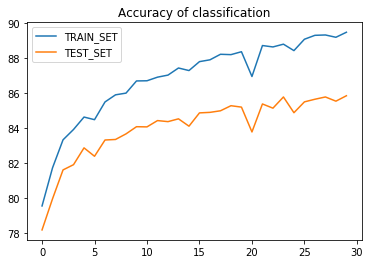

In [22]:
# Plot Results as a function of Epochs
x = np.arange(nb_epochs)
plt.plot(x, accuracies, x, test_accuracies)
plt.title("Accuracy of classification")
plt.legend(['TRAIN_SET', 'TEST_SET'])
plt.show()